In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]

Using TensorFlow backend.


In [6]:
feature_file = "BTO_25C_wb3_processed_rescale_16_16"
img_shape = (60, 100)

features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

model = BGMModel()
model.train(features, n_clusters=200, preprocessors=[])

silhouette = model.compute_silhouette_score(features)
calinski = model.compute_calinski_harabaz_score(features)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

scores = np.array(model.score(features))
Z = model.coloring(scores.reshape(img_shape))

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :, :], aspect=1)
# fig.savefig("img/Z.pdf", bbox_inches='tight', figsize=(5, 4), dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'features/BTO_25C_wb3_processed_rescale_16_16.npy'

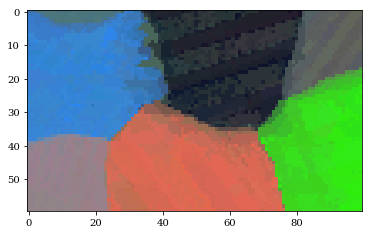

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :, :], aspect=1)